In [262]:
import pandas as pd
import numpy as np

df = pd.read_csv('EV_files/EV_train.csv')
df.set_index('House ID', inplace=True)

houses_w_nans = df[pd.isnull(df).any(axis=1)]
houses_missing_data = houses_w_nans.index.tolist()

df = df[~df.index.isin(houses_missing_data)]

In [263]:
df.head(3)

,Interval_1,Interval_2,Interval_3,Interval_4,Interval_5,Interval_6,Interval_7,Interval_8,Interval_9,Interval_10,...,Interval_2871,Interval_2872,Interval_2873,Interval_2874,Interval_2875,Interval_2876,Interval_2877,Interval_2878,Interval_2879,Interval_2880
House ID,,,,,,,,,,,,,,,,,,,,,
11655099,0.950,0.826,0.361,0.238,0.342,0.233,0.351,0.194,0.292,0.234,...,0.664,0.783,0.601,0.639,0.417,0.439,0.226,0.190,0.710,0.728
11633257,0.353,0.327,0.358,0.292,0.285,0.304,0.361,0.342,0.355,0.348,...,0.536,0.558,0.622,0.634,0.513,0.421,0.273,0.296,0.291,0.289
11651552,0.150,0.181,0.150,0.150,0.131,0.125,0.088,0.106,0.094,1.019,...,2.125,0.881,0.481,1.194,0.138,0.119,0.038,0.088,0.056,0.113


In [264]:
df.shape

(1586, 2880)

Let's calculate the total demand for these 1586 homes and see if we can use a forecasting model to predict future demand.

In [265]:
demand = df.sum()

We don't know the actual dates of the data, but let's reset the index to half-hour date time intervals just so we can have a more concrete interpretation of our data and results, since this is just an excecise.

In [266]:
rng = pd.date_range('1/1/2017', periods=2880, freq='30Min')
demand.index = rng

# break into 80/20 train/test split
demand_train = demand[:2304]
demand_test = demand[2304:]

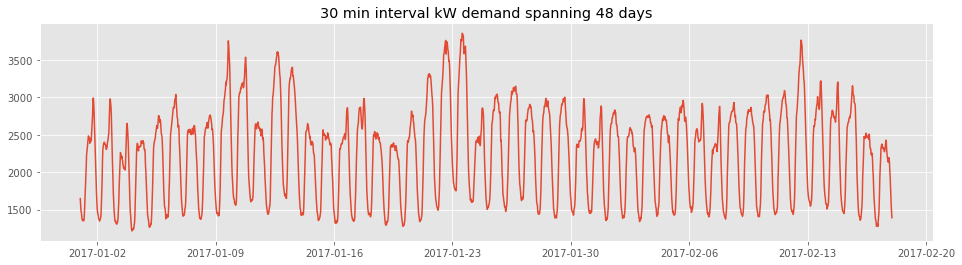

In [278]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(name)
    
fig, axs = plt.subplots(1, figsize=(16, 4))
plot_trend_data(axs, '30 min interval kW demand spanning 48 days', demand_train)

2304 30-min intervals span 48 days. We can See the daily perdiodicty and some weird spikes going on.

Likely, not enough data to capture seasonality but day of the week indicators or weekday/weekend dummy variables should certainly be applicable. Unfortunately, I don't have the actual dates associated with the intervals to be able to apply historical temperature data.

Let's start by capturing the linear trend in demand data by fitting a simple linear model and using its predictions on the training data.

In [268]:
import statsmodels.api as sm

def to_col_vector(arr):
    """Convert a one dimensional numpy array to a column vector."""
    return arr.reshape(-1, 1)

def make_design_matrix(arr):
    """Construct a design matrix from a numpy array, including an intercept term."""
    return sm.add_constant(to_col_vector(arr), prepend=False)

In [269]:
def fit_linear_trend(series):
    """Fit a linear trend to a time series.  Return the fit trend as a numpy array."""
    X = make_design_matrix(np.arange(len(series)) + 1)
    linear_trend_ols = sm.OLS(series.values, X).fit()
    linear_trend = linear_trend_ols.predict(X)
    return linear_trend

In [270]:
def plot_linear_trend(ax, name, series):
    linear_trend = fit_linear_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, linear_trend)

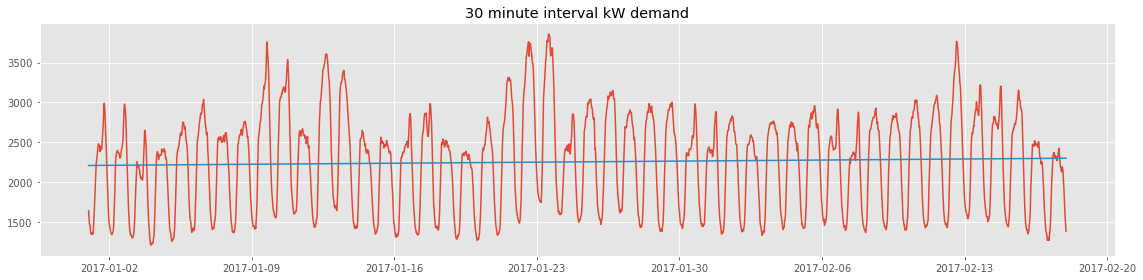

In [271]:
fig, ax = plt.subplots(1, figsize=(16, 4))
plot_linear_trend(ax, '30 minute interval kW demand', demand_train)
plt.tight_layout()

Slight upward trend. Perhaps we're trending into the summer where AC is required (remember the dates on the graph are made up). But we obviously can't capture the periodicity in our training data with our linear model, so let's move on to some more advanced methods. First, one that's fairly intutive, a simple moving average.

A very general approach that can be used for detrending data is to compute a **moving average**.

The moving average estimate of the trend at a data point $y_i$ is

$$ \hat y_i = \frac{1}{2w + 1} \sum_{j = -w}^{w} y_{i + j} $$

We esentially slide a *window* of a fixed side across our data, and average the values of the series within the window.

The parameter $w$ controls how far to the left and to the right of $w_i$ we look when averaging the nearby points, this is called the **window**.

In [286]:
def fit_moving_average_trend(series, window=6):
    return series.rolling(window=window,center=True).mean()

def plot_moving_average_trend(ax, name, series, window=6):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)

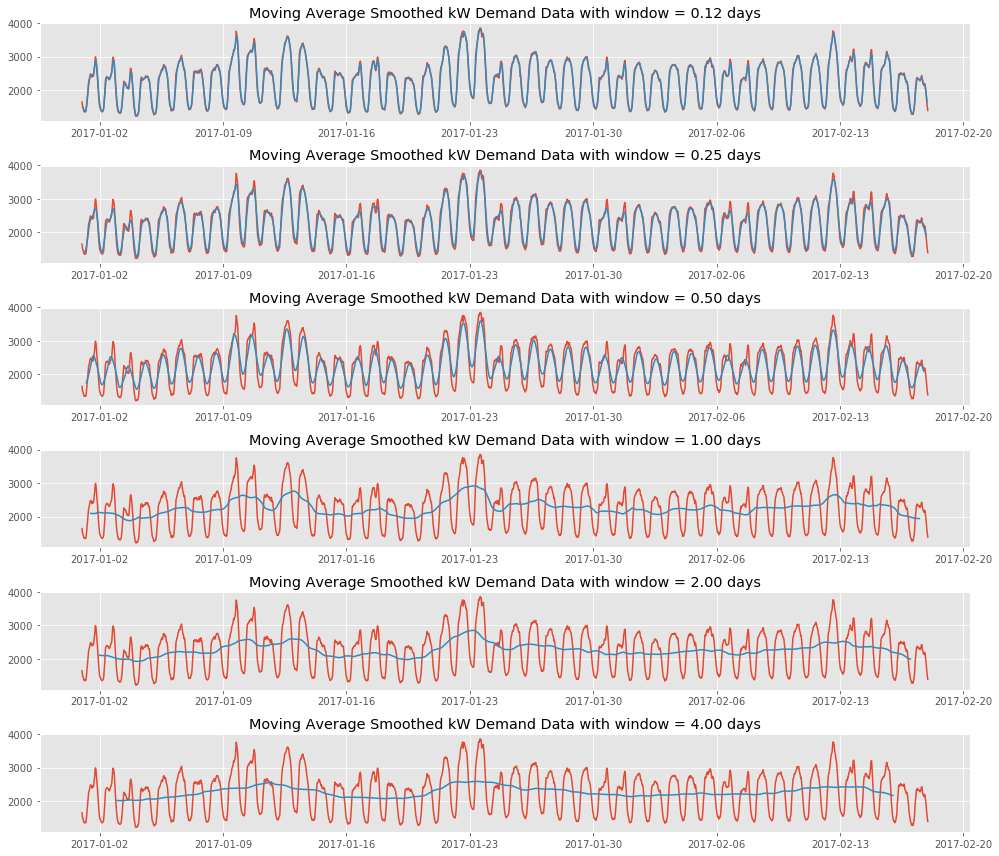

In [288]:
fig, axs = plt.subplots(6, figsize=(14, 12))

for i, window in enumerate([6, 12, 24, 48, 96, 192]):
    axs[i].plot(demand_train.index, demand_train)
    axs[i].plot(demand_train.index, fit_moving_average_trend(demand_train, window=window))
    axs[i].set_title("Moving Average Smoothed kW Demand Data with window = {:.2f} days".format(window/48))
    
plt.tight_layout()

Let's see what fitting a simple linear regrssion to the data using dummy variables for day of the week looks like.

In [305]:
def create_dow_dummies(series):
    dow = series.index.dayofweek
    # Only take 6 of the 7 dummies to avoid colinearity.
    return pd.get_dummies(dow).iloc[:, :6]

In [306]:
def fit_dow_trend(series):
    dummies = create_dow_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    dow_model = sm.OLS(series.values, X).fit()
    return dow_model.predict(X)

In [307]:
def plot_dow_trend(ax, name, series):
    dow_average_trend = fit_dow_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, dow_average_trend)

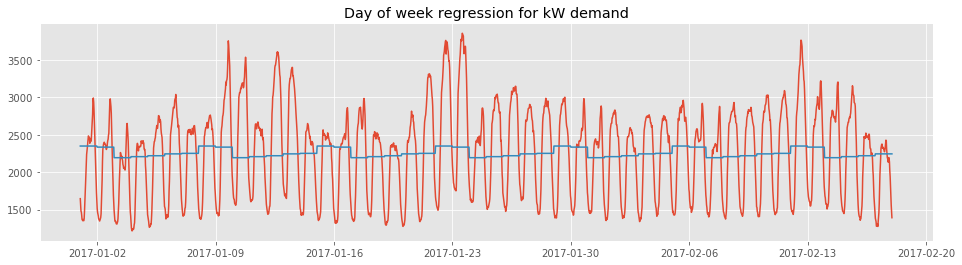

In [317]:
fig, ax = plt.subplots(1, figsize=(16, 4))

plot_dow_trend(ax, 'Day of week regression for kW demand', demand_train)

A 2-day period representing weekends stick out. This isn't suprising as people likely spend more time at home on weekends as opposed to at work. Let's try it on half hour basis.

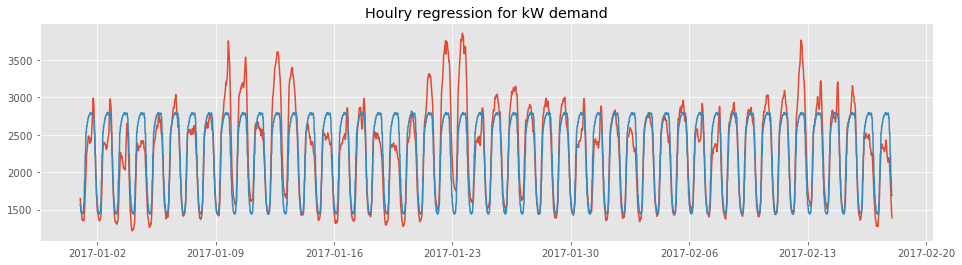

In [319]:
def create_hourly_dummies(series):
    hourly = series.index.hour
    # Only take 23 of the 24 dummies to avoid colinearity.
    return pd.get_dummies(hourly).iloc[:, :23]

def fit_hourly_trend(series):
    dummies = create_hourly_dummies(series)
    X = sm.add_constant(dummies.values, prepend=False)
    hourly_model = sm.OLS(series.values, X).fit()
    return hourly_model.predict(X)

def plot_hourly_trend(ax, name, series):
    hourly_average_trend = fit_hourly_trend(series)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, hourly_average_trend)
    
fig, ax = plt.subplots(1, figsize=(16, 4))

plot_hourly_trend(ax, 'Houlry regression for kW demand', demand_train)

Not bad. We're not catching the peaks very well, but we're certainly picking up on daily demand cycles.

pandas.core.series.Series

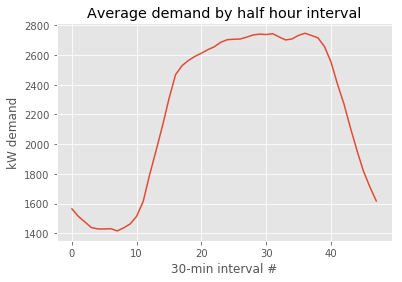

In [274]:
intervals = range(0,48)  # 48 half hour intervals in a day
avg_demand_by_tod = []
for i in intervals:
    inter = interval_data[i::48]
    avg_demand_by_tod.append(sum(inter)/len(inter))

plt.plot(intervals, half_hour_avg_charging)
plt.title('Average demand by half hour interval')
plt.ylabel('kW demand')
plt.xlabel('30-min interval #')

type(interval_data)

Time series forecasting uses only information on the variable to be forecast, and makes no attempt to discover the factors which affect its behavior. Therefore it will extrapolate trend and seasonal patterns, but it ignores all other information such as marketing initiatives, competitor activity, changes in economic conditions, and so on.

Time series models used for forecasting include ARIMA models, exponential smoothing and structural models.

Predictor variables can also be used in time series forecasting. For example, suppose we wish to forecast the hourly electricity demand (ED) of a hot region during the summer period. A model with predictor variables might be of the form

ED=f(current temperature, strength of economy, population,time of day, day of week, error).
ED=f(current temperature, strength of economy, population,time of day, day of week, error).
The relationship is not exact---there will always be changes in electricity demand that cannot be accounted for by the predictor variables. The “error” term on the right allows for random variation and the effects of relevant variables that are not included in the model. We call this an “explanatory model” because it helps explain what causes the variation in electricity demand.

Because the electricity demand data form a time series, we could also use a time series model for forecasting. In this case, a suitable time series forecasting equation is of the form

EDt+1=f(EDt,EDt−1,EDt−2,EDt−3,…,error),

where tt is the present hour, t+1t+1 is the next hour, t−1t−1 is the previous hour, t−2t−2 is two hours ago, and so on. Here, prediction of the future is based on past values of a variable, but not on external variables which may affect the system. Again, the "error" term on the right allows for random variation and the effects of relevant variables that are not included in the model.

There is also a third type of model which combines the features of the above two models. For example, it might be given by

EDt+1=f(EDt,current temperature, time of day, day of week, error).

[Source](https://www.otexts.org/fpp/1/4)

The best model to use depends on the availability of historical data, the strength of relationships between the forecast variable and any explanatory variables, and the way the forecasts are to be used.


Let's start with a pure forecast model. Let's ignore any explanatory variables (i.e. day of the week) that we can engineer for the time being. We'll hold out 20% of the data (12 days) to predict on.

In [275]:
train = interval_data[0:2304]
test = interval_data[2304:]

In [276]:
print(len(train), len(test))

2304 576
